In [1]:
%matplotlib ipympl
from matplotlib import colormaps
import matplotlib.pyplot as plt
import numpy as np
from functools import partial
from onix.data_tools import get_experiment_data
from onix.analysis.fitter import Fitter
from onix.analysis.helper import group_and_average_data
from tqdm import tqdm
import pprint

In [2]:
def gaussian(f, f_0, a, sigma, b, c):
    numerator = (f - f_0) ** 2
    denominator = 2 * sigma ** 2
    return a * np.exp(-numerator / denominator) + c + b * (f - f_0)

def get_gaussian_fit(detunings, voltages, p0=None, bounds=None):
    fitter = Fitter(gaussian)
    fitter.set_absolute_sigma(False)
    fitter.set_data(detunings, voltages)
    fitter.set_p0({"f_0": 0, "c": 1, "b": 0, "sigma": 1})
    if p0 is not None:
        fitter.set_p0(p0)
    if bounds is not None:
        for bound_var, bound in bounds.items():
            fitter.set_bounds(bound_var, bound[0], bound[1])
    fitter.fit(maxfev = 1000000)
    return fitter


In [122]:
def plot_raw_data(data, label = None, note = None):
    """
    Plot the raw voltages from the transmission and monitor photodiodes. 
    """
    fig, ax = plt.subplots(1, 2, figsize = (12, 5))
    if isinstance(data, int):
        data_numbers = [data]
    elif isinstance(data, tuple):
        data_numbers = range(data[0], data[1]+1)
    elif isinstance(data, list):
        data_numbers = data

    if len(data_numbers) == 1:
        transmission_data = get_plotting_data(data_numbers[0], normalize=False, fitit=False, return_monitor = False) 
        for i, label in enumerate(transmission_data[0]):
            ax[0].scatter(transmission_data[1][i], transmission_data[2][i], label=f"{data_numbers[0]} - {label}")

        monitor_data = get_plotting_data(data_numbers[0], normalize=False, fitit=False, return_monitor = True)
        for i, label in enumerate(monitor_data[0]):
            ax[1].scatter(monitor_data[1][i], monitor_data[2][i], label=f"{data_numbers[0]} - {label}")
    else:        
        colors = [f"C{i}" for i in range(10)]
        markers = [".","x","o","+","s""v","^","<",">",",","1","2","3","4","8","p","P","h","H"]
        for j, data_number in enumerate(data_numbers):
            transmission_data = get_plotting_data(data_number, normalize=False, fitit=False, return_monitor = False) 
            for i, label in enumerate(transmission_data[0]):
                color = colors[j]
                marker = markers[i]
                ax[0].scatter(transmission_data[1][i], transmission_data[2][i], label=f"{data_number} - {label}", color=color, marker=marker)
    
        for j, data_number in enumerate(data_numbers):
            monitor_data = get_plotting_data(data_number, normalize=False, fitit=False, return_monitor = True)
            for i, label in enumerate(monitor_data[0]):
                color = colors[j]
                marker = markers[i]
                ax[1].scatter(monitor_data[1][i], monitor_data[2][i], label=f"{data_number} - {label}", color=color, marker=marker)
                
    ax[0].set_xlabel("Optical detuning (MHz)")
    ax[0].set_ylabel("Transmission (V)")
    ax[0].legend()
    ax[0].text(0,1.02,data, transform = ax[0].transAxes)
    ax[1].set_xlabel("Optical detuning (MHz)")
    ax[1].set_ylabel("Monitor (V)")
    ax[1].legend()
    ax[1].text(0,1.02,data, transform = ax[1].transAxes)

    if note is not None:
        ax[0].text(0.1,0.1, note, transform = ax[0].transAxes)
    plt.tight_layout()
    plt.show()

In [14]:
def get_plotting_data(data_number, normalize=True, fitit=False, labels=None, return_monitor = False):
    # GET DATA
    data, headers = get_experiment_data(data_number)
    detunings_MHz = headers["detunings"].to("MHz").magnitude
    transmissions_avg, transmissions_err = group_and_average_data(data["transmissions_avg"], headers["params"]["detect"]["cycles"], return_err=True)
    monitors_avg, monitors_err = group_and_average_data(data["monitors_avg"], headers["params"]["detect"]["cycles"], return_err=True)

    # ARRAYS TO RETURN
    labels_new = []
    xs = []
    ys = []
    ys_err = []
    xfits = []
    yfits = []
    
    # LOOP THROUGH ALL LABELS (SET BY ["detect"]["cycles"][LABEL] IN THE params DICT)
    for i, ((label, transmission), (_, transmission_err), (_, monitor), (_, monitor_err)) in enumerate(
        zip(transmissions_avg.items(), 
            transmissions_err.items(), 
            monitors_avg.items(),
            monitors_err.items(),
           )
        ):
        
        # IF LABELS NOT SPECIFICIED: RETURN ALL LABELS. 
        # ELSE ONLY PLOT SPECIFIED LABELS
        if labels is None:
            pass
        else:
            if label not in labels:
                continue

        # NORMALIZE WITH MONITORS PD
        if normalize:
            y_err = (transmission/monitor)*np.sqrt((transmission_err/transmission)**2 + (monitor_err/monitor)**2)
            y = transmission / monitor
        elif return_monitor:
            y_err = monitor_err
            y = monitor
        else:
            y_err = transmission_err
            y = transmission
            
        # TODO: UPDATE MASK SETTINGS FOR E>0, E<0
        mask = detunings_MHz < 1e13

        labels_new.append(label)
        xs.append(detunings_MHz[mask])
        ys.append(y)
        ys_err.append(y_err)

        # FITTER
        if fitit:
            xfit = np.linspace(min(detunings_MHz[mask]), max(detunings_MHz[mask]), 1000)
            fitter = get_gaussian_fit(detunings_MHz[mask], y[mask], p0 = {"sigma": 0.5, "a": -0.1, "b": -0.00001, "c": np.max(transmission[mask])})
            xfits.append(xfit)
            yfits.append(fitter.fitted_value(xfit))

    # RETURN WITH OR WITHOUT FITS
    if fitit:
        return (labels_new, xs, ys, ys_err, xfits, yfits)
    else:
        return (labels_new, xs, ys, ys_err)
    


In [84]:
def plot_antihole_data(data, normalize=True, fitit=False, errors=False, labels=None, return_monitor = False):
    """
    input data: integer data number, or tuple data numbers for range, or list of data numbers
    """
    if isinstance(data, int):
        data_numbers = [data]
    elif isinstance(data, tuple):
        data_numbers = range(data[0], data[1]+1)
    elif isinstance(data, list):
        data_numbers = data
    
    colors = [f"C{i}" for i in range(10)]
    markers = [".","x","+","s""v","^","<",">",",","1","2","3","4","8","p","P","h","H"]
    fig, ax = plt.subplots()
    for j, data_number in enumerate(data_numbers):
        plotting_data = get_plotting_data(data_number, normalize=normalize, fitit=fitit, labels=labels, return_monitor = return_monitor)
        
        for i, label in enumerate(plotting_data[0]):
            color = colors[j]
            marker = markers[i]
            if errors:
                ax.errorbar(plotting_data[1][i], plotting_data[2][i], plotting_data[3][i], ls="", marker=marker, label=f"{data_number} - {label}", color=color)
            else:
                ax.scatter(plotting_data[1][i], plotting_data[2][i], marker=marker, label=f"{data_number} - {label}", color=color)
            if fitit:
                ax.plot(plotting_data[4][i], plotting_data[5][i], label=f"{data_number} - {label} fit", color=color)
                
    ax.set_xlabel("Optical detuning (MHz)")
    if normalize:
        ax.set_ylabel("Normalized transmission (V/V)")
    else:
        if return_monitor is False:
            ax.set_ylabel("Transmission (V)")
        else:
            ax.set_ylabel("Monitor (V)")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [13]:
def print_data_number(data_number):
    """
    easier to read headers dictionary with this
    """
    _, headers = get_experiment_data(data_number)
    pp = pprint.PrettyPrinter(depth=4)
    pp.pprint(headers)


# PLOTTING OPTICAL SPECTRUM
### plot_antihole_data(data_numbers, normalize=True, fitit=False, errors=True, labels=None)
    - data number input: data_numbers as int, tuple, or list 
    - normalize: normalizes to monitors PD
    - fitit: fit to gaussian and plot fit
    - errors: include errorbars ------------> CHECK it seems too small
    - labels: select which labels to plot, e.g. labels=["rf"] only plots only rf labelled data
                   if labels is None: plots all data

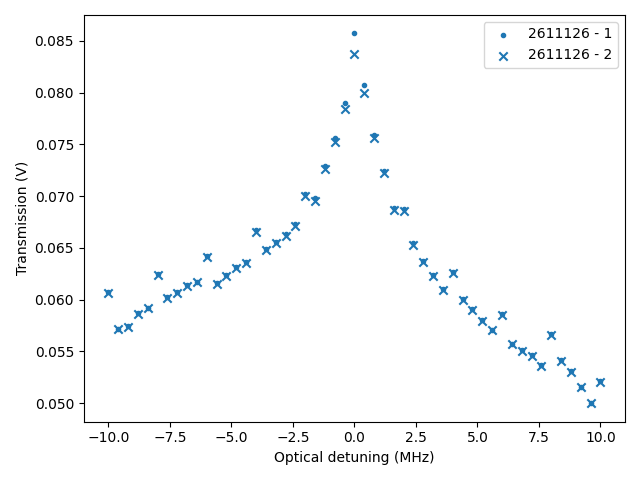

In [85]:
plot_antihole_data(2611126, normalize=False, fitit=False, errors=False, labels=None)

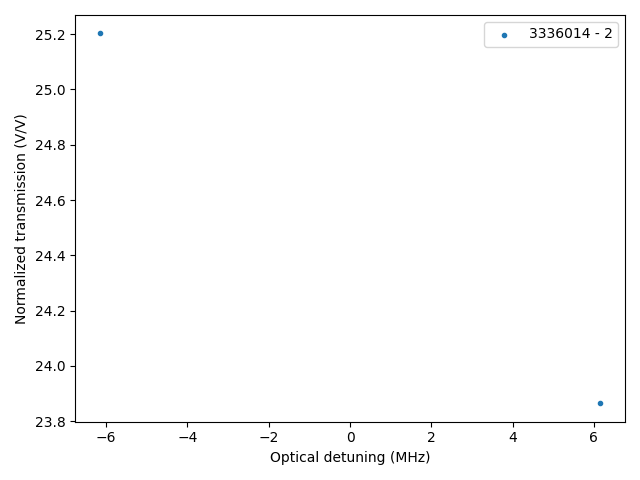

In [86]:
plot_antihole_data(3336014)

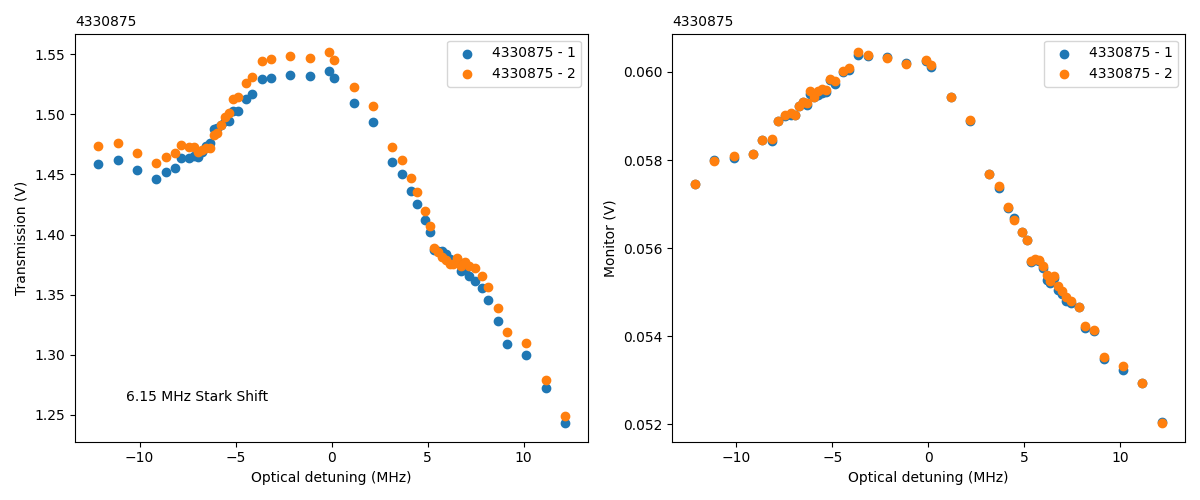

In [127]:
plot_raw_data(4330875, note = "6.15 MHz Stark Shift")

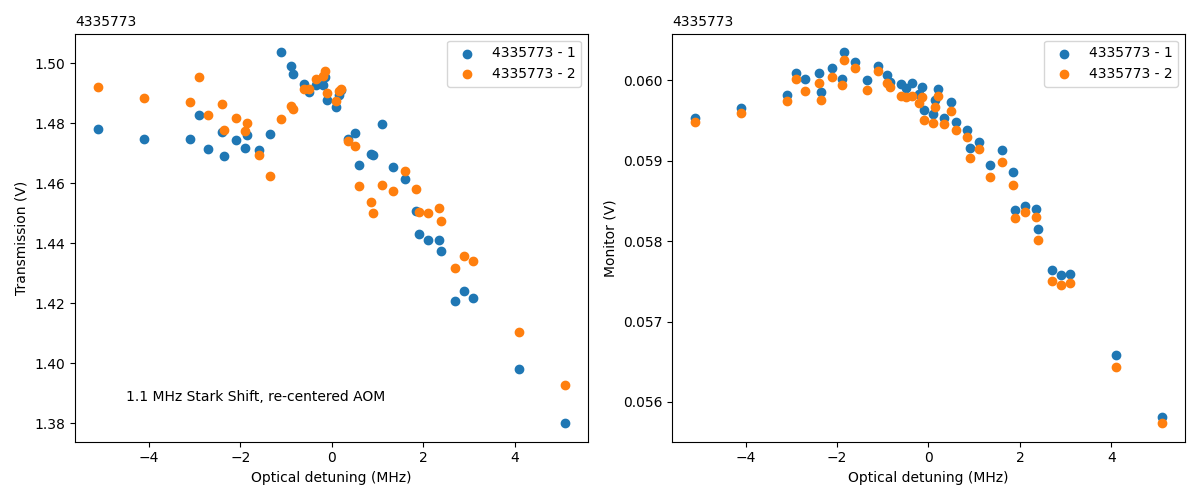

In [128]:
plot_raw_data(4335773, note = "1.1 MHz Stark Shift, AOM moved 1 MHz lower")

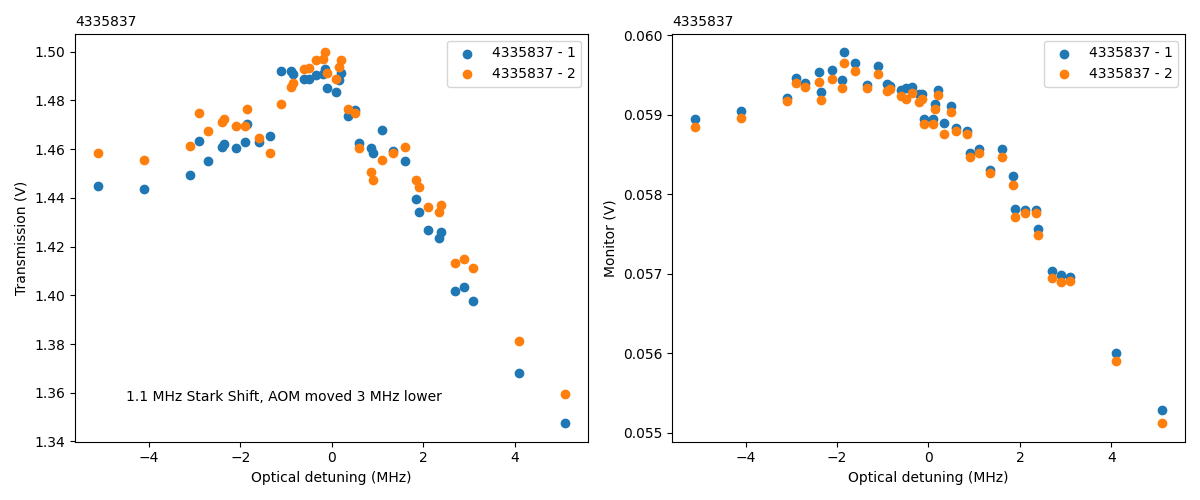

In [130]:
plot_raw_data(4335837, note = "1.1 MHz Stark Shift, AOM moved 3 MHz lower")

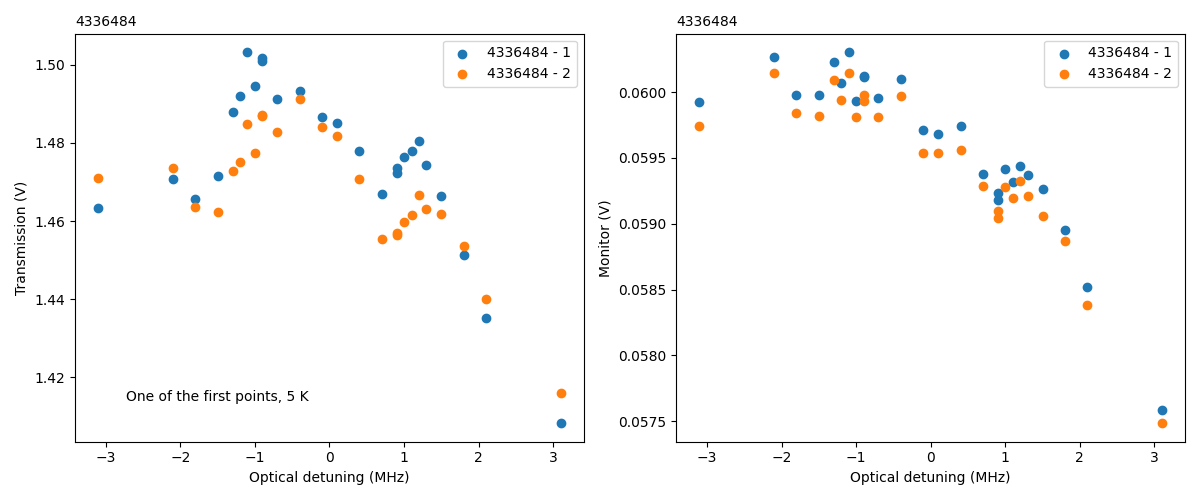

In [134]:
plot_raw_data(4336484, note = "One of the first points, 5 K" )

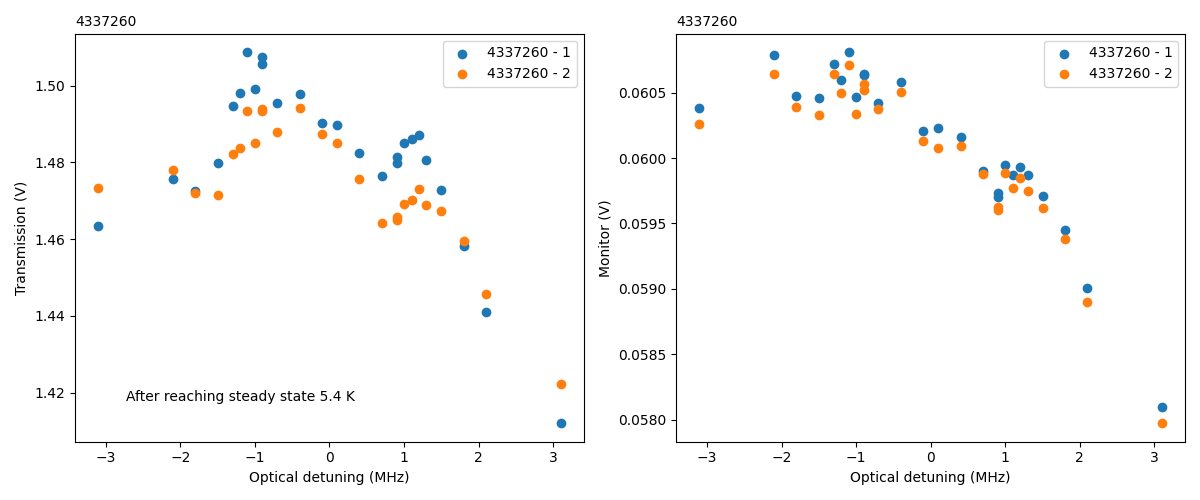

In [133]:
plot_raw_data(4337260, note = "After reaching steady state 5.4 K")

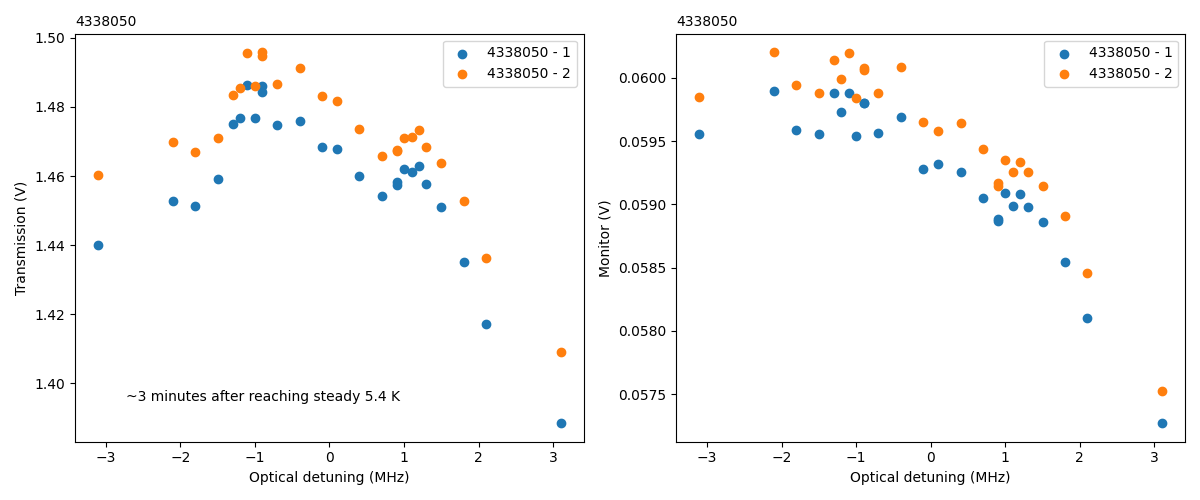

In [135]:
plot_raw_data(4338050, note = "~3 minutes after reaching steady 5.4 K")

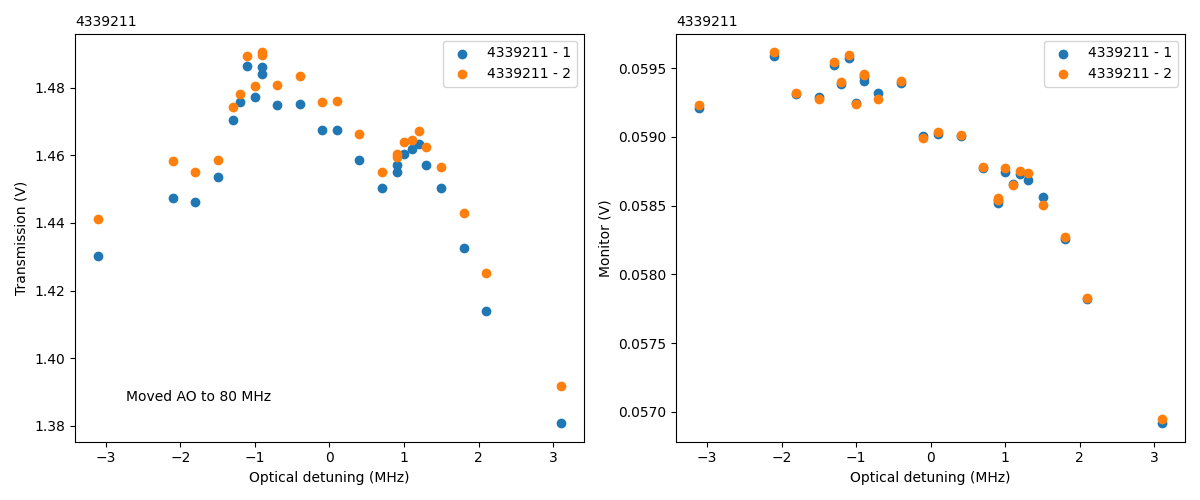

In [139]:
plot_raw_data( 4339211, note = "Moved AO to 80 MHz")